# Physics 261: Class 21
## 25 Mar 2024
<hr style="border-top: 1px solid purple; margin-top: 1px; border: 3px solid purple"></hr>
 The goals for today:

    1. Questions about HW for tomorow?
    2. Reminder about how to import data to Julia
    3. Create some fake data and export it to csv
    4. Import the data
    5. Fitting data to our model
    6. Obtaining uncertainties
    
<hr style="margin-bottom: 1px; border: 3px solid purple"></hr>


## In Class / Homework
Using the 4th order Runge-Kutta method, let's revisit the simple harmonic oscillator: 

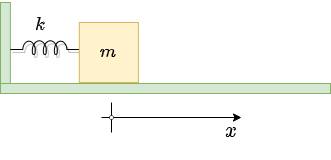

### Create a RK4 function
Now create a function called `RK4(x₀, v₀, tmax, Δt)` which computes and returns the:<br>
    a) position<br>
    b) velocity<br>
    c) kinetic energy, $K$<br>
    d) potential energy, $U$<br>
    e) total energy, $E=K+U$<br>
as functions of time.
The input parameters to this function are<br>
`x₀, v₀, tmax, Δt` <br>
the initial position ($x_0$), velocity ($v_0$), and the maximum simulation time (tmax), and the time step ($\Delta t$). Let's use $k/m \equiv 1.0$.

You might find it helpful to look at the notebook from class 10 (12 Feb). 
Compare the RK4 method to the Euler-Cromer method. For a given time step, how much better is RK4 at conserving energy?

You will find it helpful to revisit the notebook from Class 10. 

Upload your completed work by 10 am on Tuesday 26 Mar to https://www.dropbox.com/request/4Njt4ApewrQVfcJMkuaA



In [1]:
using CSV
using DataFrames
using LsqFit
using Distributions
using LaTeXStrings
using Measures
using LinearAlgebra
using Plots

In [2]:
default(fontfamily = "Computer Modern", size=(1200,800), titlefont = (16), legendfontsize = 10, 
        guidefont = (16, :darkgreen), tickfont = (12, :black), 
        framestyle = :box, yminorgrid = true, xminorgrid= true,legend = :topright, dpi=300, margin = 7mm)

## How to import data

In [3]:
sound = DataFrame(CSV.File("Whistle.csv"));

In [4]:
t = data[!,1]
s = data[!,2];

LoadError: UndefVarError: `data` not defined

In [5]:
plot(t,s,size=(1200,500), ylabel="Sound Pressure (Pa?)", xlabel="time (s)")

LoadError: UndefVarError: `t` not defined

## Let's make some fake data
We'll define a function to create a damped exponential and add some noise to simulate actual data; our model function is 
$$ \mathrm{model}(t,p) = p_1 * \exp\left(-\frac{t}{p_2}\right) \cos(p_3 t + p_4) $$

In [6]:
model(t, p) = p[1] * exp.(-t./p[2]) .* cos.(p[3]*t .+ p[4]);

### Now create our signam and add noise to it

In [7]:
tmin, tmax, N_times = 0.0, 10.0, 200
Δy = 0.20
dt = (tmax-tmin)/N_times
tdata = collect(LinRange(tmin,tmax,N_times))
δt = 0.1*dt*ones(length(tdata))
δy  = rand(Normal(0, Δy),length(tdata))
ydata = model(tdata, [2.0, 3.0, 2π, 0.0]) + δy;

### Plot the fake data and the noise signal

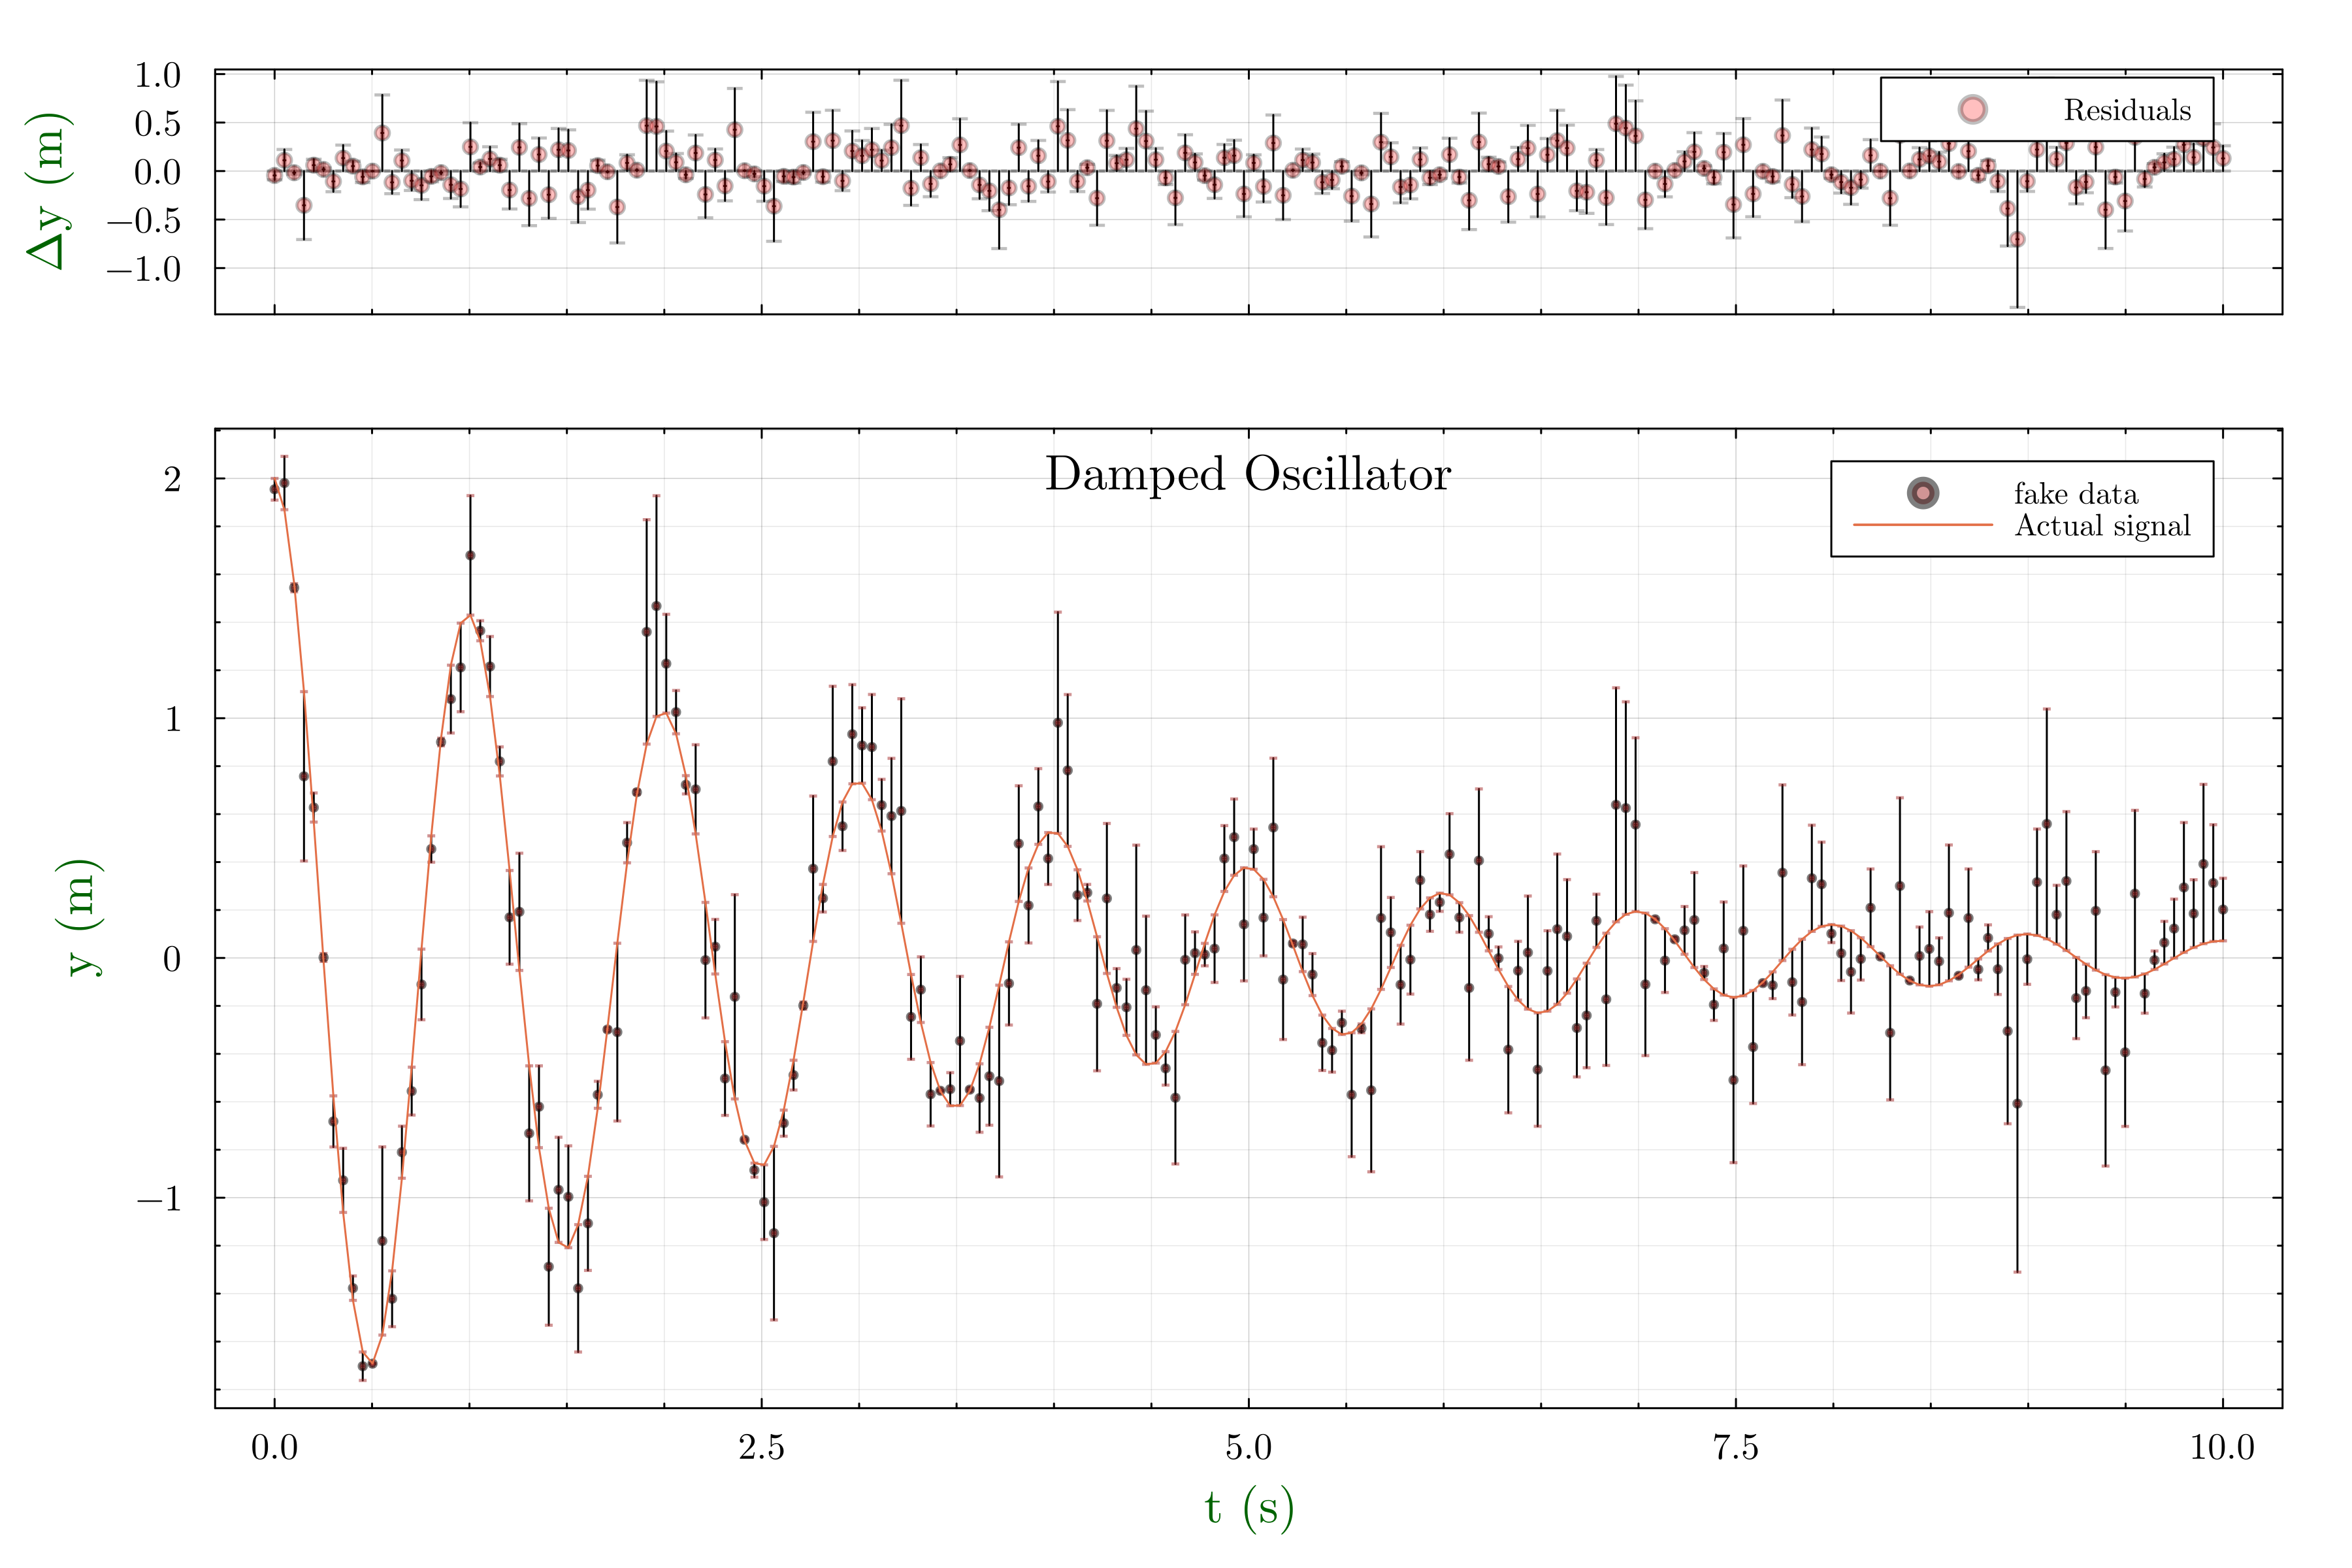

In [8]:
plot1 = scatter(tdata, ydata, xerr=δt, yerr=δy, marker=:circle, markersize=2, markeralpha=0.5,
     markercolor=:brown, label = "fake data", xlabel = "t (s)", ylabel = "y (m)", 
     title = "Damped Oscillator", legend = :topright, dpi=600, top_margin=-10mm)
plot!(tdata, model(tdata, [2.0, 3.0, 2π, 0.0]), label="Actual signal")

plot2 = scatter(tdata, δy, color=:red, label="Residuals", 
         xlabel =" ", ylabel = "Δy (m)",
        xerr = δt, yerr=δy,  marker=:circle, markersize=4, markeralpha=0.25,
        xformatter=_->"", yminorgrid=false)


plot(plot2, plot1, layout=grid(2, 1, heights=[0.2 ,0.8], link=:x, margin=10mm))

## Now save this fake data to a CSV file:

In [9]:
# combine the two vectors into a DataFrame:
data_to_save = DataFrame(t = tdata, y = ydata);

In [10]:
# write the DataFrame to a CSV file
CSV.write("SHO_data.csv", data_to_save)

"SHO_data.csv"

## Now import the data:

### Make a plot of the raw data

## Now use the CurveFit.jl package to find the best fit

In [11]:
"""
fit_data(model, tdata, ydata, p0)

Fit the model function `model` to the data `ydata` at time points `tdata`
using initial parameters `p0`.

# Arguments
- `model::Function`: The model function to fit.
- `tdata::Vector`: A vector of time points.
- `ydata::Vector`: A vector of corresponding data points.
- `p0::Vector`: A vector of initial parameter values.

# Returns
A tuple `(fit_params, σ)` of the fitted parameter values and their standard deviations.

# Example
```julia
model(x, p...) = p[1] .* exp.(-p[2] .* x) .* sin.(p[3] .* x .+ p[4])
tdata = range(0, 10, length=100)
ydata = model(tdata, 1.0, 0.5, 2π, π/2) + randn(size(tdata))
p0 = [1.0, 1.0, 2π, π/2]
fit_params, σ = fit_data(model, tdata, ydata, p0)
"""
function fit_data(model, tdata, ydata, p0)
    fit = curve_fit(model, tdata, ydata, p0)
    fit_params = fit.param
    σ = stderror(fit)
    return fit_params, σ # returns a tuple of fit parameters and their standard deviations
end

fit_data

### Notes on fitting data so more complicated models
When you fit data to some arbitrary model with N parameters, you have to make an 
intial guess for each parameter; it's easy for any fitting program to give an incorrect result,
and you have to be skeptical of the output "best fit" parameters returned. If you initial guess is 
to far off, the fitting program can give incorrect results, or outright fail to converge.

In [12]:
#initial guess for fit:
p0 = [1.0, 1.0, 2.0, 1.0];

p0, σ0 = fit_data(model, tdata, ydata, p0)
println(round.(p0; digits=4))
println(round.(σ0; digits=4))

[1.9912, 3.2039, 6.2671, 0.001]
[0.075, 0.1776, 0.0177, 0.0393]


## Now plot the original data with the fit

# Exercise: Read in TrialData.csv
Now read in the file TrialData.csv and figure out the best fit to this data.